<a href="https://colab.research.google.com/github/yiyichanmyae/time_series/blob/main/4_4_CNN_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
  # %tensorflow_version only exists in colab
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


2.12.0
time : [0.000e+00 1.000e+00 2.000e+00 ... 1.456e+03 1.457e+03 1.458e+03]


Cause: could not parse the source code of <function windowed_dataset.<locals>.<lambda> at 0x78cc421bb640>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function windowed_dataset.<locals>.<lambda> at 0x78cc421bb640>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function windowed_dataset.<locals>.<lambda> at 0x78cbb5e91870>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function windowed_dataset.<locals>.<lambda> at 0x78cbb5e91870>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/100
31/31 [==============================] - 17s 34ms/step - loss: 169525748170752.0000
Epoch 2/100
31/31 [==============================] - 1s 14ms/step - loss: 240410722304.0000
Epoch 3/100
31/31 [==============================] - 1s 10ms/step - loss: 17002531840.0000
Epoch 4/100
31/31 [==============================] - 1s 12ms/step - loss: 1202460928.0000
Epoch 5/100
31/31 [==============================] - 1s 9ms/step - loss: 85039600.0000
Epoch 6/100
31/31 [==============================] - 1s 14ms/step - loss: 6014182.0000
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 426102.2188
Epoch 8/100
31/31 [==============================] - 1s 16ms/step - loss: 30817.1465
Epoch 9/100
31/31 [==============================] - 1s 9ms/step - loss: 2843.5166
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 870.9214
Epoch 11/100
31/31 [==============================] - 1s 13ms/step - loss: 732.3679
Epoch 12/100
31/31 [===============

Cause: could not parse the source code of <function model_forecast.<locals>.<lambda> at 0x78cbb5e91f30>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function model_forecast.<locals>.<lambda> at 0x78cbb5e91f30>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45/45 [==============================] - 0s 7ms/step
CPU times: user 47.3 s, sys: 5.61 s, total: 52.9 s
Wall time: 1min 17s


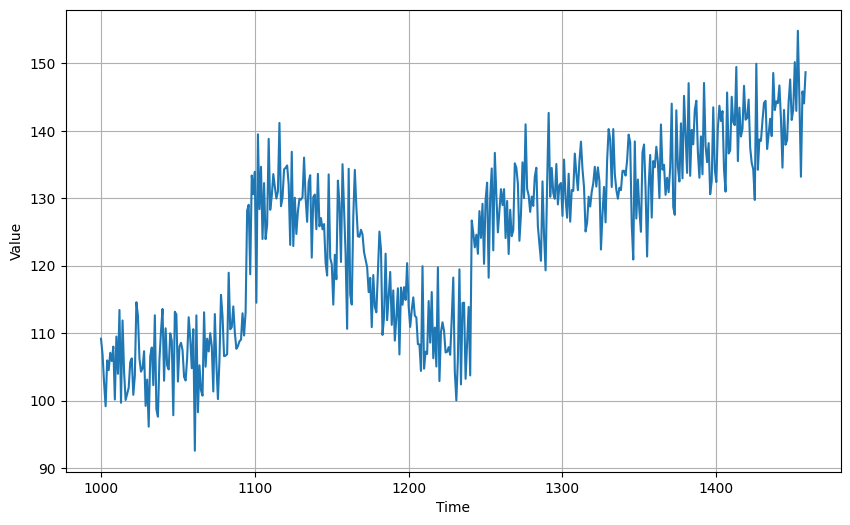

In [1]:
%%time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return time*slope

def seasonal_pattern(season_time):
  "just an arbitrary pattern"
  return np.where(season_time < 0.4,
                  np.cos(season_time*2*np.pi),
                  1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) /period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 - 1, dtype="float32")
print(f"time : {time}")
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size +1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128,
                           kernel_size=3,
                           strides=1,
                           padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=1)

def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size : -1, -1, 0]


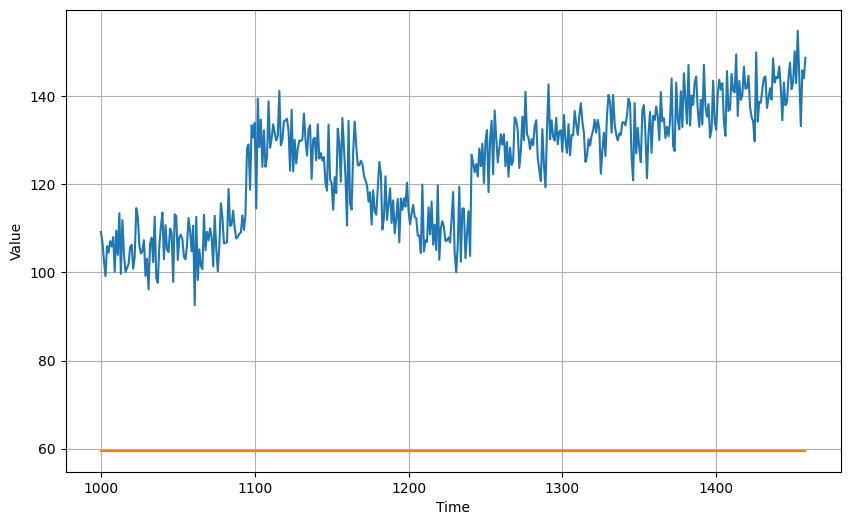

In [2]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [3]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

64.75237